# TMDB 5000 Movie Dataset Analysis and Modeling
- By **Arshia Goshtasbi**
- Github: [@Arshiagosh](https://github.com/Arshiagosh)

**Description:**
The Movie Database provides movie data for public use. Given that major films costing over $100 million to produce can still flop, Analyse this data is more important than ever to the industry. Can we tell the direction of films and changes budget over time? Which languages are most popular ? Can we classify the data to we can predict in the future?
This is a great place to start digging in to those questions, with data on the plot, cast, crew, budget, and revenues of several thousand films.

## Importing Libraries

In [1]:
# Importing related libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud # For most repeated words
import json

## Data Loading
Importing the two datasets and merging them.

### Data cards

The Movie Database provides two datasets:
**tmdb_5000_movies.csv (Movie credits data):**
- budget
- genres
- homepage
- id
- keywords
- original_language
- original_title
- overview
- popularity
- production_companies
- production_countries
- release_date
- revenue
- runtime
- spoken_languages
- status
- tagline
- title
- vote_average
- vote_count

**tmdb_5000_credits.csv:**
- movie_id
- title
- cast
- crew

We will merge the two datasets in order to get all the information about the actors and the directors of their relative movie.

In [2]:
# Importing the datasets
credits_df=pd.read_csv('tmdb_5000_credits.csv')
movies_df=pd.read_csv('tmdb_5000_movies.csv')

In [3]:
# Merging
credits_df.columns = ['id','tittle','cast','crew']
df= credits_df.merge(movies_df,on='id')

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4803 non-null   int64  
 1   tittle                4803 non-null   object 
 2   cast                  4803 non-null   object 
 3   crew                  4803 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   keywords              4803 non-null   object 
 8   original_language     4803 non-null   object 
 9   original_title        4803 non-null   object 
 10  overview              4800 non-null   object 
 11  popularity            4803 non-null   float64
 12  production_companies  4803 non-null   object 
 13  production_countries  4803 non-null   object 
 14  release_date          4802 non-null   object 
 15  revenue              

## Data Cleaning and Preprocessing
There are some NaNs and unavailable data in the database. \
It's required to clean these datas and prepare it for the next section (EDA - Exploratory Data Analysis).

In [5]:
# Making a Copy to don't mess the data for the Modeling section.
df_EDA = df.copy(deep=True)
# Finding howmany Nulls are there.
df_EDA.isnull().sum()

id                         0
tittle                     0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [6]:
# Dropping the unrelated info for the EDA
df_EDA.drop(['homepage', 'tagline', 'id', 'overview', 'original_title', 'tittle'] ,axis = 1,inplace = True)

In [7]:
# Replacing the 2 null runtimes with the mean of all movies
df_EDA['runtime'] = df_EDA['runtime'].fillna(df_EDA['runtime'].mean())

In [8]:
# Removing any NaN
df_EDA = df_EDA.dropna()
# Removing any Duplicates
df_EDA = df_EDA.drop_duplicates()
# Counting the null values in each attribute
df_EDA.isnull().sum()

cast                    0
crew                    0
budget                  0
genres                  0
keywords                0
original_language       0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
dtype: int64

In [9]:
# Creating a Year feature for easier analysis
df_EDA['release_date'] = pd.to_datetime(df_EDA['release_date'])
df_EDA['year'] = df_EDA['release_date'].dt.year
df_EDA['year']

0       2009
1       2007
2       2015
3       2012
4       2012
        ... 
4798    1992
4799    2011
4800    2013
4801    2012
4802    2005
Name: year, Length: 4802, dtype: int32

In [10]:
# Creating a profit and is_profitable feature for easier analysis
df_EDA['profit'] = df_EDA['revenue'] - df_EDA['budget']
df_EDA['is_profitable'] = df_EDA['profit'] > 0

In [11]:
# A simple Overview
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4802 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cast                  4802 non-null   object        
 1   crew                  4802 non-null   object        
 2   budget                4802 non-null   int64         
 3   genres                4802 non-null   object        
 4   keywords              4802 non-null   object        
 5   original_language     4802 non-null   object        
 6   popularity            4802 non-null   float64       
 7   production_companies  4802 non-null   object        
 8   production_countries  4802 non-null   object        
 9   release_date          4802 non-null   datetime64[ns]
 10  revenue               4802 non-null   int64         
 11  runtime               4802 non-null   float64       
 12  spoken_languages      4802 non-null   object        
 13  status                4

In [12]:
# Head of the DF
df_EDA.head(5)

,cast,crew,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,year,profit,is_profitable
0,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800,2009,2550965087,True
1,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500,2007,661000000,True
2,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466,2015,635674609,True
3,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Dark Knight Rises,7.6,9106,2012,834939099,True
4,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,John Carter,6.1,2124,2012,24139100,True


## EDA (Exploratory Data Analysis)

### Overview  

**Q0** : First overview.

In [13]:
df_EDA.describe()

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,year,profit
count,4.802000e+03,4802.000000,4802,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000,4.802000e+03
mean,2.905109e+07,21.496776,2002-12-27 23:45:54.352353280,8.227777e+07,106.898116,6.093440,690.361724,2002.468763,5.322668e+07
min,0.000000e+00,0.000372,1916-09-04 00:00:00,0.000000e+00,0.000000,0.000000,0.000000,1916.000000,-1.657101e+08
25%,8.000000e+05,4.671734,1999-07-14 00:00:00,0.000000e+00,94.000000,5.600000,54.000000,1999.000000,-7.997688e+05
50%,1.500000e+07,12.924931,2005-10-03 00:00:00,1.917498e+07,103.500000,6.200000,235.500000,2005.000000,2.529443e+06
75%,4.000000e+07,28.332017,2011-02-16 00:00:00,9.291920e+07,117.750000,6.800000,737.000000,2011.000000,5.533980e+07
max,3.800000e+08,875.581305,2017-02-03 00:00:00,2.787965e+09,338.000000,10.000000,13752.000000,2017.000000,2.550965e+09
std,4.072447e+07,31.818451,NaN,1.628697e+08,22.556893,1.191496,1234.674268,12.414354,1.359797e+08


**Q1** : Which movie have high popularity over all years ?

In [14]:
def find_popularity(year_1 = 0 , year_2 = 0) :
    sorted_popularity = df_EDA.sort_values(by = 'popularity',ascending= False)
    if year_2 == 0 :
        year_2 = year_1
    if year_1 != 0 :
        sorted_popularity.query('year >= @year_1 and year <= @year_2',inplace = True)
    plt.subplots(figsize=(10,8))
    plt.gca().invert_yaxis()
    plt.barh(sorted_popularity['title'].head(10),sorted_popularity['popularity'].head(10))

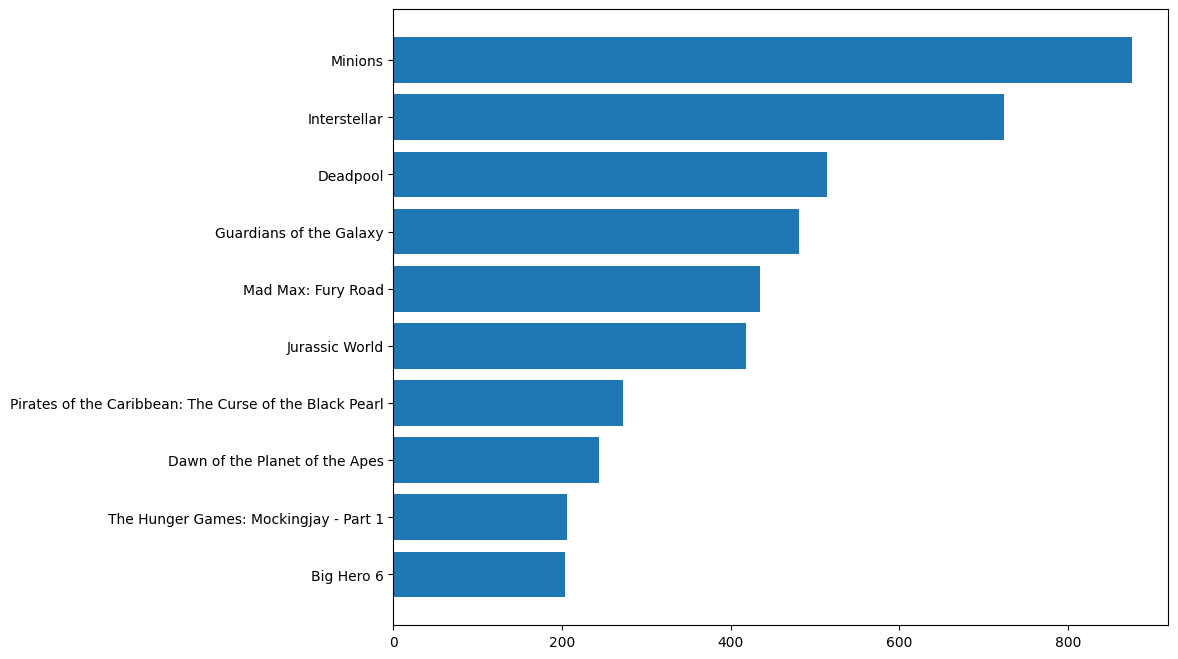

In [15]:
find_popularity()

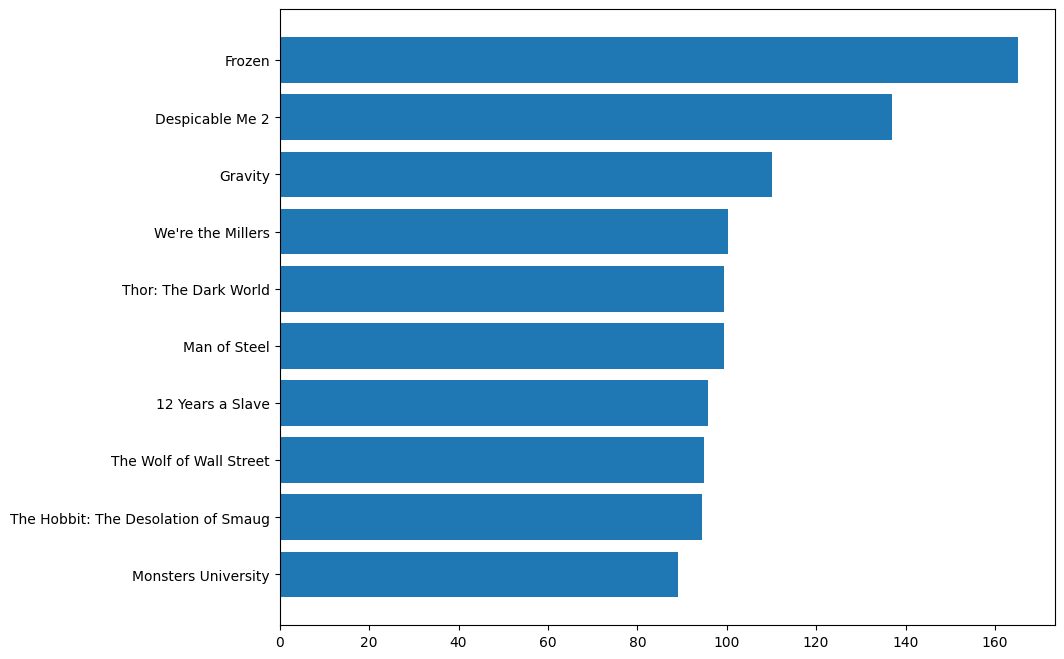

In [16]:
find_popularity(2013) # For the year == 2013

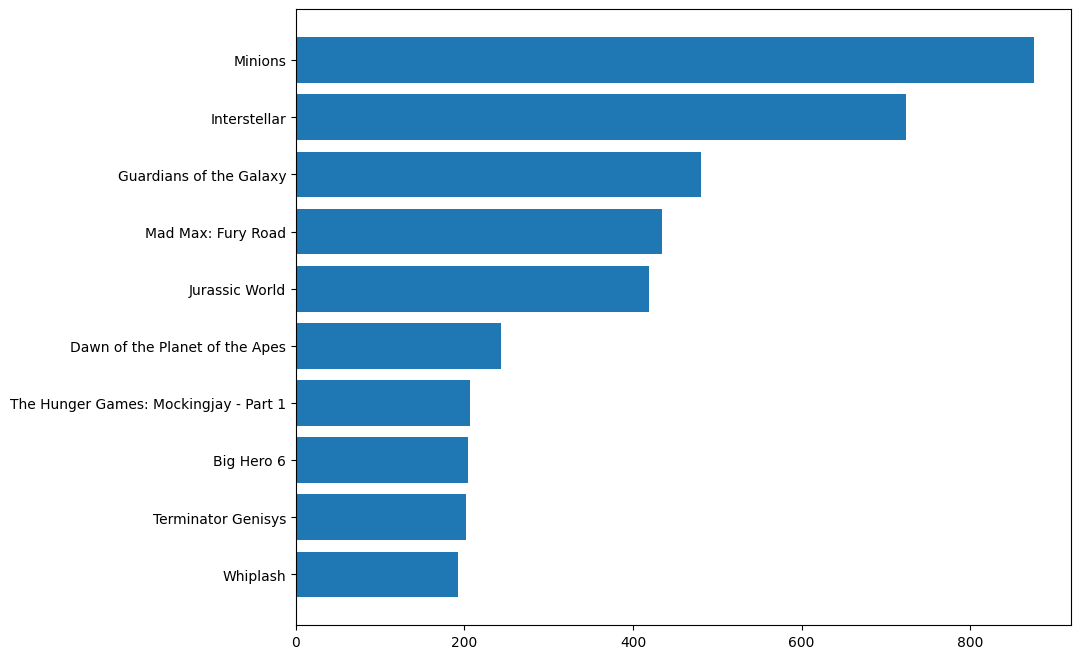

In [17]:
find_popularity(2013,2015) # For the 2013 <= year <= 2015

**Q2** : Which Genres have high popularity over all years ?

In [18]:
def find_genres(year_1 = 0 , year_2 = 0) :
    sorted_popularity = df_EDA.sort_values(by = 'popularity',ascending= False)
    if year_2 == 0 :
        year_2 = year_1
    if year_1 != 0 :
        sorted_popularity.query('year >= @year_1 and year <= @year_2',inplace = True)
    z = list()
    print(sorted_popularity.shape)
    counter = 0
    for i in sorted_popularity['genres'] :
        i = json.loads(i)
        for dic in i :
            dict(dic)
        z.append(dic.get('name'))
        counter +=1
        if counter >=sorted_popularity['genres'].shape[0]/2 :
            break
    unique_genres = set(z)
    counts = dict()
    for i in z:
      counts[i] = counts.get(i, 0) + 1 
    plt.subplots(figsize=(10,8))
    plt.gca().invert_yaxis()
    plt.barh(list(counts.keys()),list(counts.values()))

(4802, 20)


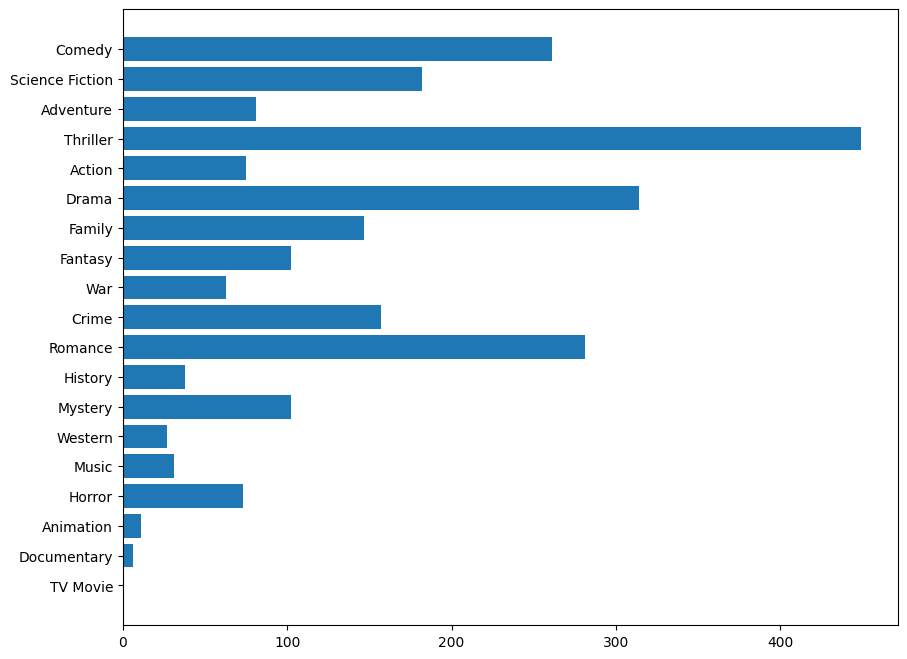

In [19]:
find_genres()

(227, 20)


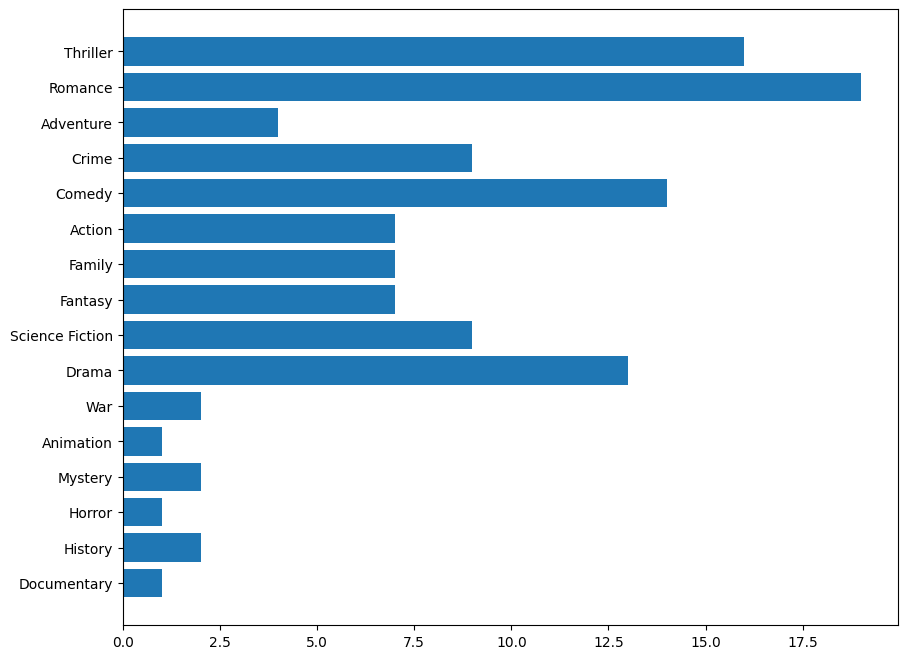

In [20]:
find_genres(2008) # For the year == 2008

(656, 20)


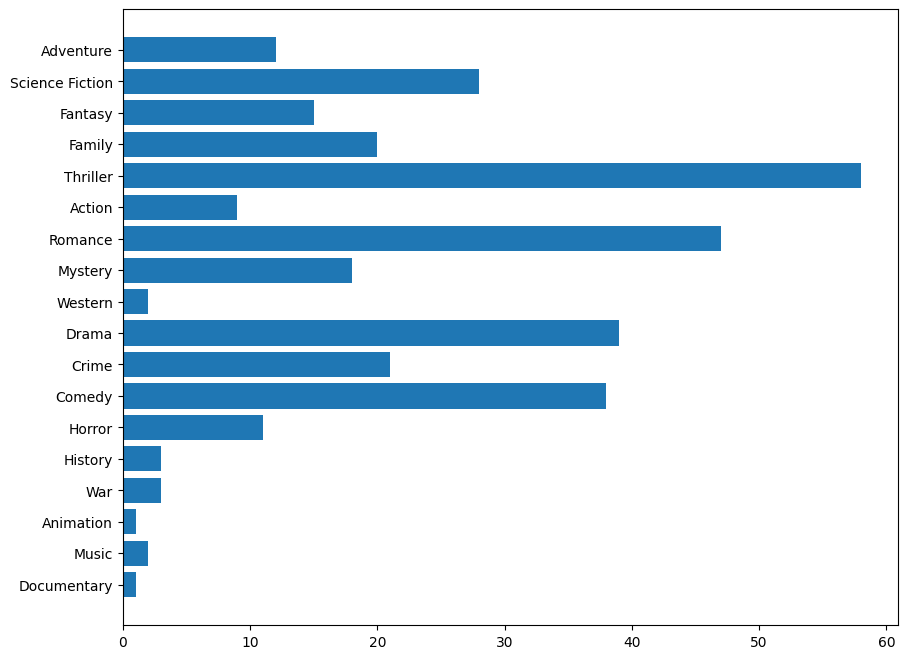

In [21]:
find_genres(2010,2012) # For the 2010 <= year <= 2012

**Q3** : Which companies make the high revenues?

In [22]:
sorted_revenues = df_EDA.sort_values(by = 'revenue',ascending= False)
low_revenues = df_EDA[df_EDA['revenue'] < df_EDA['revenue'].median()]
high_revenues = df_EDA[df_EDA['revenue'] >= df_EDA['revenue'].median()]
z = list()
counter = 0
for i in high_revenues['production_companies'] :
    i = json.loads(i)
    for dic in i :
        dict(dic)
    z.append(dic.get('name'))
unique_genres = set(z)
counts = dict()
for i in z:
    counts[i] = counts.get(i, 0) + 1 
s = pd.DataFrame(list(counts.values()),list(counts.keys()),columns=['counts'])
s= s.sort_values(by='counts',ascending= False)
print(s)

                                                    counts
Warner Bros.                                            91
Paramount Pictures                                      45
Touchstone Pictures                                     40
Metro-Goldwyn-Mayer (MGM)                               38
Universal Pictures                                      32
...                                                    ...
Internationale Scarena Filmproduktionsgesellsch...       1
Captivate Entertainment                                  1
Cantharus Productions                                    1
Showbox                                                  1
Kathbur Pictures                                         1

[1320 rows x 1 columns]


**Q4** : Which production companies have produced most films?

In [23]:
# Extract Companies from JSON objects
companies_list = []
for companies_str in df_EDA['production_companies']:
    data = json.loads(companies_str)
    names = [item['name'] for item in data]
    companies_list.extend(names)
companies_count = {i:companies_list.count(i) for i in companies_list}
# Sort the dictionary by company count
sorted_companies_count = dict(sorted(companies_count.items(), key=lambda item: item[1], reverse=True))

# Display sorted companies and their counts
for i, (company, count) in enumerate(sorted_companies_count.items()):
    if i < 5:
        print(f"{company}: {count}")
    else:
        break

Warner Bros.: 319
Universal Pictures: 311
Paramount Pictures: 285
Twentieth Century Fox Film Corporation: 222
Columbia Pictures: 201


### Correlation

**Q5** : Is there a relation between budget and revenue ?

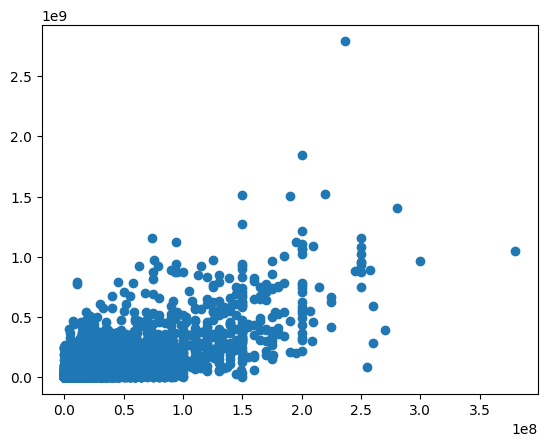

In [24]:
plt.scatter(df_EDA['budget'],df_EDA['revenue'])

**Q6** : How are the vote count and revenue related?

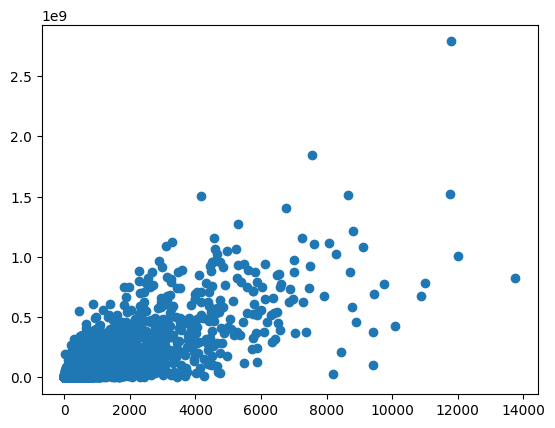

In [25]:
plt.scatter(df_EDA['vote_count'],df_EDA['revenue'])

**Q7** : How the attributes are related?

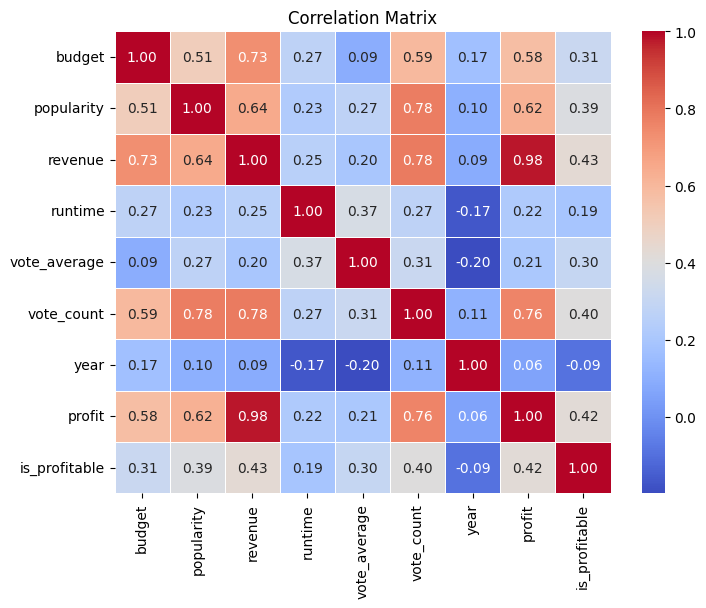

In [26]:
columns_for_corr = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'profit', 'is_profitable']
df_EDA_corr = df_EDA[columns_for_corr]
correlation_matrix = df_EDA_corr.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Changes over years

**Q8** : How have movie budget and revenue changed over time?

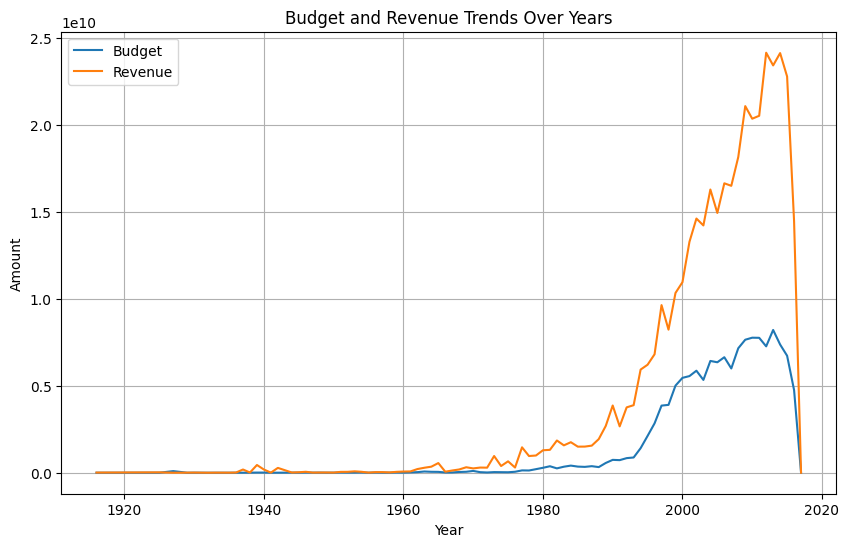

In [27]:
data_release_date = df_EDA.sort_values('year')
budget1 = data_release_date.groupby('year')['budget'].sum()
revenue1 = data_release_date.groupby('year')['revenue'].sum()
# Plotting
plt.figure(figsize=(10, 6))

# Plot budget trend
plt.plot(budget1.index, budget1.values, label='Budget')

# Plot revenue trend
plt.plot(revenue1.index, revenue1.values, label='Revenue')

# Customize the plot
plt.title('Budget and Revenue Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

**Q9** : How the genre trends have changed throughout the years?

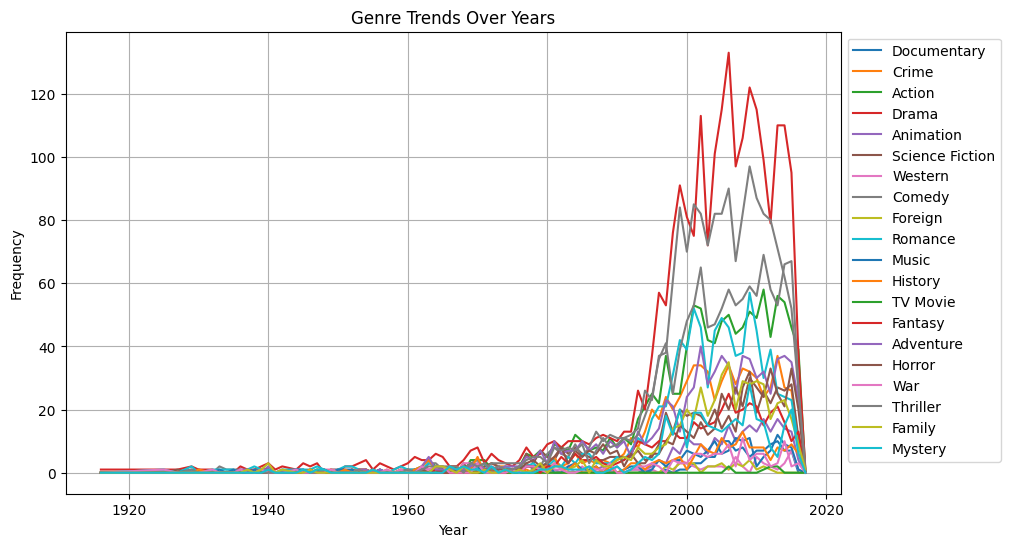

In [28]:
# Extract genres from JSON objects
genres_list = []
for genre_str in data_release_date['genres']:
    data = json.loads(genre_str)
    names = [item['name'] for item in data]
    genres_list.extend(names)

# Create a set of unique genres
unique_genres = set(genres_list)

# Initialize a dictionary to store genre counts for each year
genre_counts = {genre: [] for genre in unique_genres}

# Calculating the count of each genre in each year
for year in sorted(data_release_date['year'].unique()):
    year_data = data_release_date[data_release_date['year'] == year]
    genres_list = []
    for genre_str in year_data['genres']:
        data = json.loads(genre_str)
        names = [item['name'] for item in data]
        genres_list.extend(names)
    genres_list = {i : genres_list.count(i) for i in genres_list}
    for genre in unique_genres:
        try:
            genre_counts[genre].append(genres_list[genre])
        except KeyError:
            genre_counts[genre].append(0)

# Plot trend lines for each genre
plt.figure(figsize=(10, 6))
for genre in unique_genres:
    plt.plot(data_release_date['year'].unique(), genre_counts[genre], label=genre)

plt.title('Genre Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


**Q10** : How the runtime of movies has changed over the years?

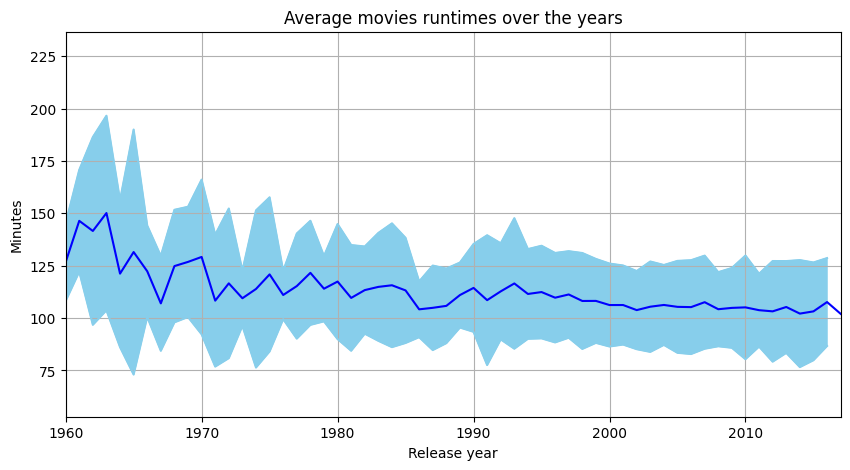

In [29]:
grouped_data = df_EDA['runtime'].groupby(df_EDA['year']).describe()
avg_runtime_by_year = grouped_data['mean']
avg_runtime_min = grouped_data['mean'] - grouped_data['std']
avg_runtime_max = grouped_data['mean'] + grouped_data['std']
fig, x = plt.subplots(figsize=(10,5))
x.plot(avg_runtime_by_year, color='blue')
x.plot(avg_runtime_min, color='skyblue')
x.plot(avg_runtime_max, color='skyblue')
x.fill_between(grouped_data.index, avg_runtime_min, avg_runtime_max, color="skyblue")
x.set_title('Average movies runtimes over the years')
x.set_xlabel('Release year')
x.set_ylabel('Minutes')
x.set_xlim(1960,2017)
plt.grid(True)
plt.show()

**Q11** : Which years/months has the number of movie releases?

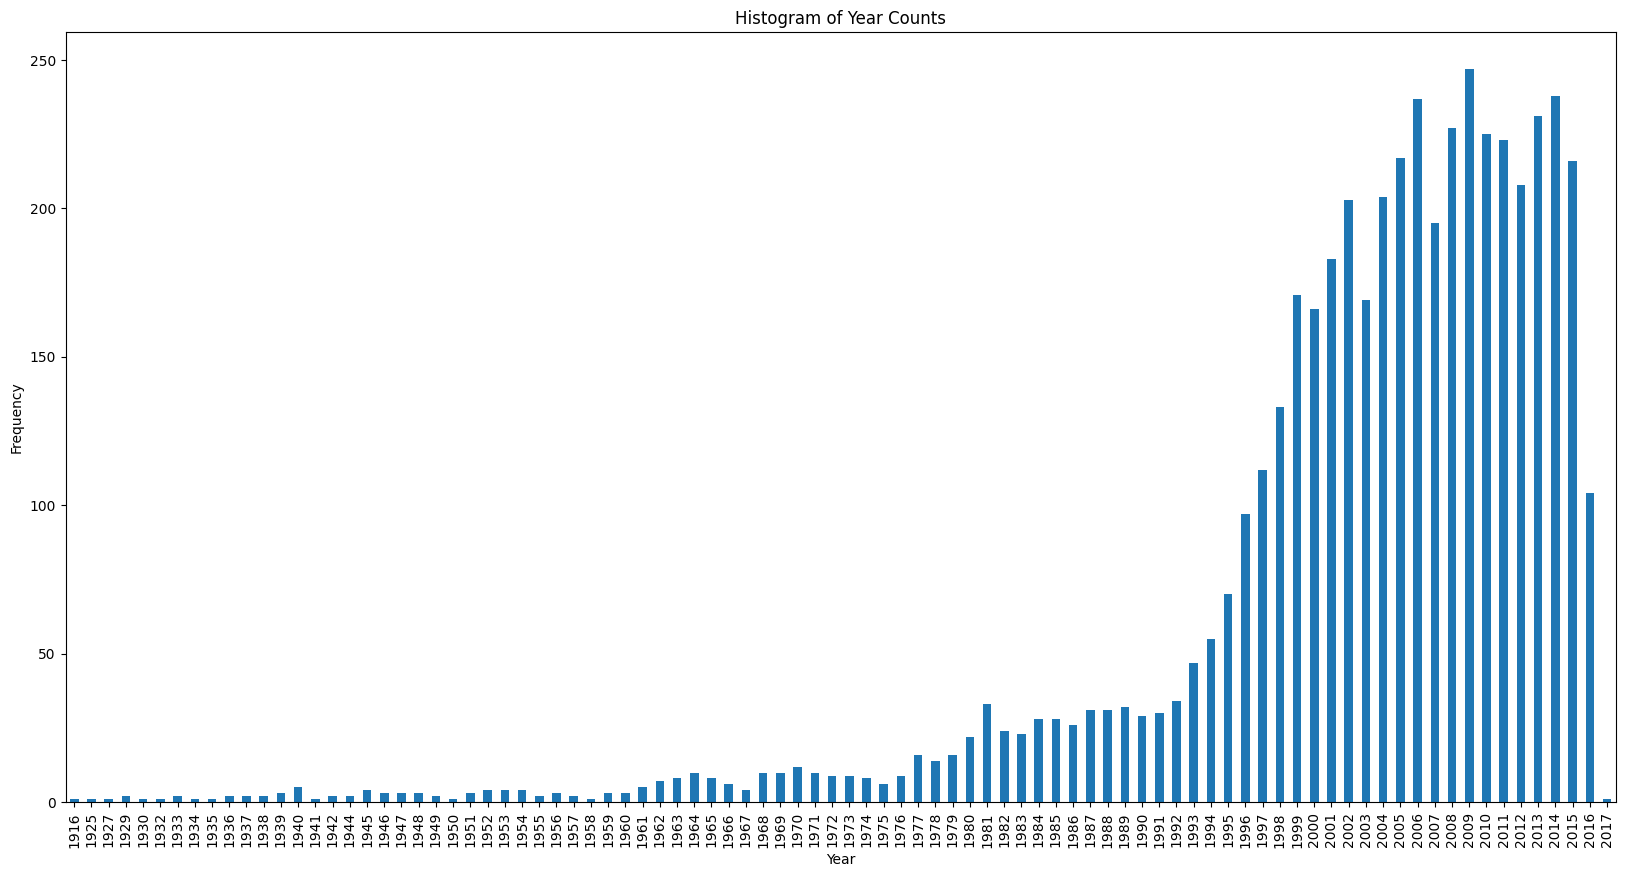

In [30]:
year_count = df_EDA.sort_values('year').groupby('year').size()
#print(year_count)
plt.figure(figsize=(20, 10))
year_count.plot(kind = 'bar')
#plt.hist(year_count.index, bins=len(year_count), weights=year_count.values, edgecolor='black')
plt.xticks(rotation= 90)
plt.title('Histogram of Year Counts')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

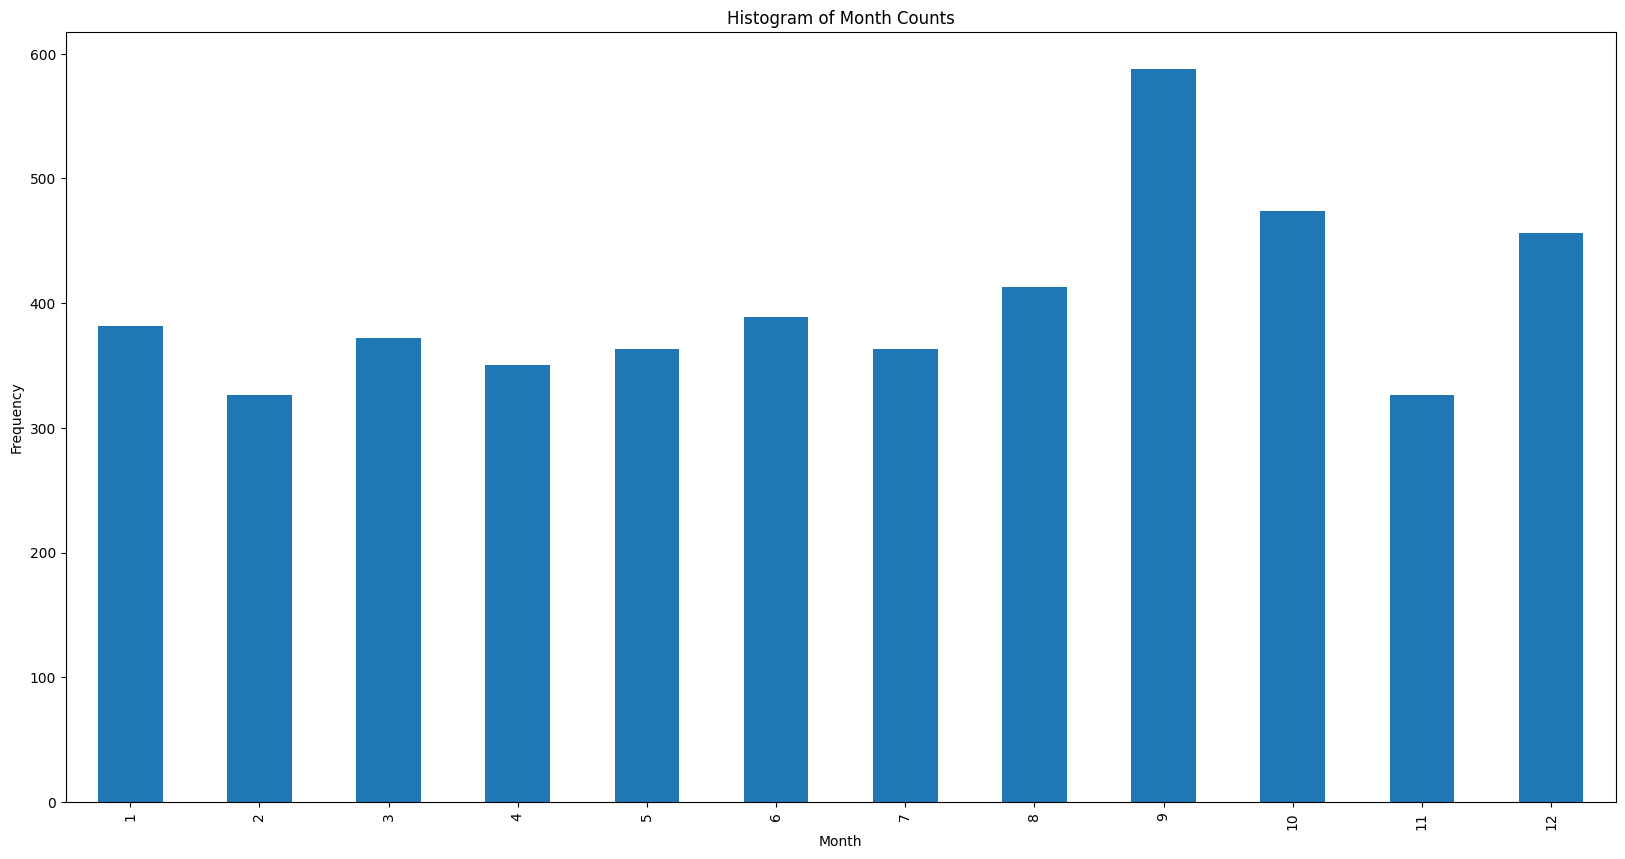

In [31]:
df_EDA['month'] = df_EDA['release_date'].dt.month
month_count = df_EDA.groupby('month').size()
plt.figure(figsize=(20, 10))
month_count.plot(kind='bar')
plt.title('Histogram of Month Counts')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

**Q12** : How the number of vote counts for movies have changed over the years?

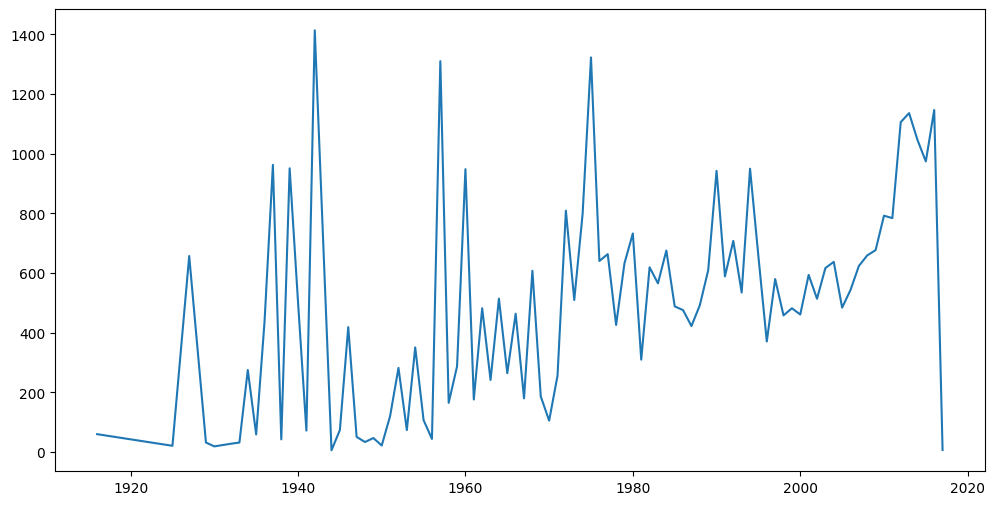

In [32]:
plt.figure(figsize=(12,6))
grouped_data = df_EDA.groupby('year')['vote_count'].mean()
plt.plot(grouped_data.index, grouped_data)
plt.show()

### Keywords

**Q13** : What are the most used keywords from the dataset?

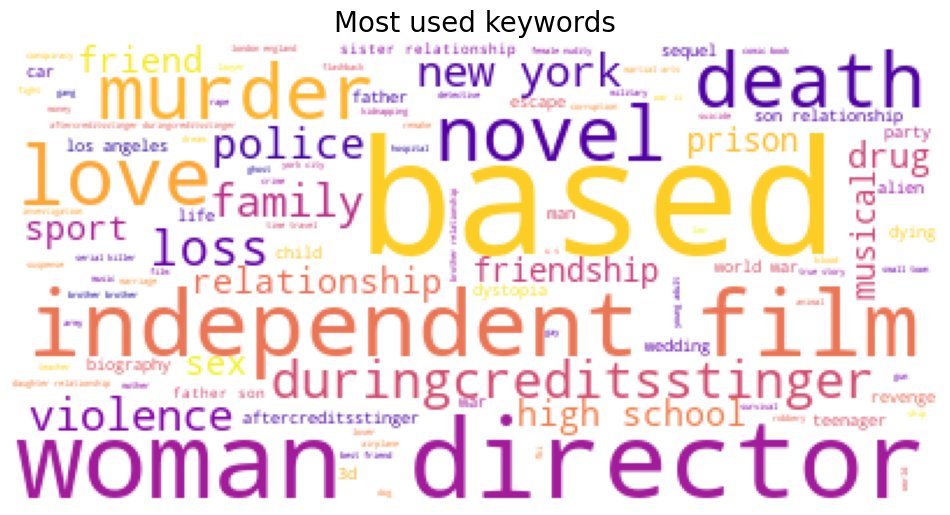

In [33]:
text = ','.join(' '.join([item['name'] for item in json.loads(keyword)]) for keyword in df_EDA['keywords'])
wc = WordCloud(max_words=100, background_color='white', colormap='plasma').generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.title("Most used keywords", fontsize = 20)
plt.axis('off')  # Hide axis
plt.show()

### Cast and their Effects

**Q14** : Who are top 50 most popular actors?

In [34]:
# Initialize a dictionary to store actors and their cumulative popularity
actors_popularity = {}

# Iterate through each movie
for index, row in df_EDA.iterrows():
    cast = json.loads(row['cast'])
    popularity = row['popularity']
    
    # Accumulate popularity for each actor
    for actor in cast:
        actor_name = actor['name']
        actors_popularity[actor_name] = actors_popularity.get(actor_name, 0) + popularity

# Sort actors by cumulative popularity
sorted_actors = sorted(actors_popularity.items(), key=lambda x: x[1], reverse=True)

# Select the top 50 actors
top_50_actors = sorted_actors[:50]
top_50_name = []
# Print the top 20 actors
for rank, (actor, popularity) in enumerate(top_50_actors, 1):
    print(f"Rank {rank}: {actor} - Cumulative Popularity: {popularity}")
    top_50_name.append(actor)


Rank 1: Stan Lee - Cumulative Popularity: 3148.7651520000004
Rank 2: Samuel L. Jackson - Cumulative Popularity: 2393.0473450000004
Rank 3: Matt Damon - Cumulative Popularity: 2324.211831000002
Rank 4: Morgan Freeman - Cumulative Popularity: 2144.355814000001
Rank 5: Geoffrey Rush - Cumulative Popularity: 2137.0505050000006
Rank 6: Johnny Depp - Cumulative Popularity: 2039.1833910000003
Rank 7: Michael Caine - Cumulative Popularity: 1898.682553
Rank 8: Bruce Willis - Cumulative Popularity: 1886.381318
Rank 9: Liam Neeson - Cumulative Popularity: 1855.6116000000002
Rank 10: Steve Carell - Cumulative Popularity: 1749.8587720000005
Rank 11: Brad Pitt - Cumulative Popularity: 1732.6732020000002
Rank 12: Anne Hathaway - Cumulative Popularity: 1605.035601
Rank 13: Gary Oldman - Cumulative Popularity: 1603.6700620000006
Rank 14: Steve Coogan - Cumulative Popularity: 1602.0252750000002
Rank 15: Ava Acres - Cumulative Popularity: 1584.745711
Rank 16: Tom Hanks - Cumulative Popularity: 1582.86127

**Q15** : Do the count of popular actors (from last Question) affect the revenue?

In [35]:
top_50_name

['Stan Lee',
 'Samuel L. Jackson',
 'Matt Damon',
 'Morgan Freeman',
 'Geoffrey Rush',
 'Johnny Depp',
 'Michael Caine',
 'Bruce Willis',
 'Liam Neeson',
 'Steve Carell',
 'Brad Pitt',
 'Anne Hathaway',
 'Gary Oldman',
 'Steve Coogan',
 'Ava Acres',
 'Tom Hanks',
 'Michael Keaton',
 'Joseph Oliveira',
 'Robert De Niro',
 'John Ratzenberger',
 'Allison Janney',
 'Sandra Bullock',
 'Cate Blanchett',
 'Stanley Tucci',
 'Scarlett Johansson',
 'Bill Hader',
 'Tom Cruise',
 'Frank Welker',
 'Zoe Saldana',
 'Arnold Schwarzenegger',
 'Matthew McConaughey',
 'Judy Greer',
 'Orlando Bloom',
 'Andy Serkis',
 'Chris Pratt',
 'Alan Tudyk',
 'Josh Brolin',
 'Robert Downey Jr.',
 'Sean Bean',
 'Hugo Weaving',
 'Elizabeth Banks',
 'Kristen Wiig',
 'Casey Affleck',
 'J.K. Simmons',
 'Ryan Reynolds',
 'Paul Bettany',
 'Harrison Ford',
 'Steve Buscemi',
 'Will Smith',
 'Stellan Skarsgård']

In [36]:
# Check if each actor in the DataFrame is among the top 50 actors
df_EDA['in_top_50'] = df_EDA['cast'].apply(lambda x: sum(actor['name'] in top_50_name for actor in json.loads(x)))
df_EDA['in_top_50']

0       1
1       4
2       0
3       5
4       0
       ..
4798    0
4799    0
4800    0
4801    0
4802    1
Name: in_top_50, Length: 4802, dtype: int64

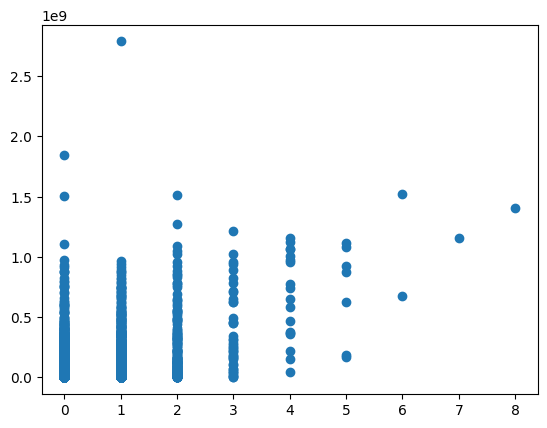

In [37]:
plt.scatter(df_EDA['in_top_50'], df_EDA['revenue'])